
Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xarray as xr
import os
import glob

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.warp import calculate_default_transform

# for working with raster data
import rioxarray

# for shapefile
import geopandas as gpd

# for MODIS conversions
import modis_utils

# for calculating zonal statistics
import aster_utils

import warnings
warnings.filterwarnings('ignore')



In [2]:


def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))





Set font sizes for plots


In [3]:


SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



---
Open data files

Open our merged GOES-CUES point timeseries dataset


In [4]:


cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()





Load MODIS timeseries of the CUES site


In [5]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)



Get filepaths for orthorectified GOES images


In [6]:


goes_directory = "/storage/GOES/orthorectified"
ortho_goes_filelist = glob.glob(goes_directory + '/**/*.tif', recursive=True)#getListOfFiles(goes_directory)





Get filepaths for ASTER images


In [7]:


aster_directory = "/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES/"
# Find all our ASTER files and their timestamps in our directory
aster = aster_utils.aster_timestamps(aster_directory, ext='tif')
# add a UTC-8 datetime for pacific standard that CUES uses
aster['datetime'] = aster.timestampUTC - pd.Timedelta(hours=8)
# save a csv file of the ASTER files we are using
#aster.to_csv('aster_AST_L1T_band14_Tuolumne-and-CUES.csv')





Find the GOES observations at the same time as ASTER


In [8]:
# create an empty dictionary we'll fill with filenames and timestamps for each subdirectory we search
goes_dict = {}
    

aster_counter = 0
# for every ASTER datetime (in UTC)
for aster_datetime_UTC in aster.timestampUTC:
    # count
    aster_counter += 1
    #print('\n\n File {} of {}'.format(aster_counter, aster.shape[0]))
    #print('\nFor ASTER observation at {}'.format(aster_datetime_UTC))
    # find the GOES subdirectory for the corresponding year-month-day and hour
    goes_subdir = r"/{year}/{month}/{day}/{product}/{hour}/{channel}/".format(
                            goes_directory=goes_directory, 
                            year=aster_datetime_UTC.strftime('%Y'), 
                            month=aster_datetime_UTC.strftime('%m'), 
                            day=aster_datetime_UTC.day, 
                            product='ABI-L1b-RadC', 
                            hour=aster_datetime_UTC.strftime('%H'), 
                            channel='C14')
    # now within this subdirectory, the same hour of this ASTER observation
    #print('\nSearching for GOES ABI imagery within:\n{}{}'.format(goes_directory,goes_subdir))
    # get the filenames of each GOES ABI image in this subdirectory
    goes_files = glob.glob(goes_directory+goes_subdir+'*.tif')
    goes_datetimes_UTC_list = []
    goes_files_list = []
    

    for this_goes_file in goes_files:

        this_goes_filename = os.path.normpath(this_goes_file).split('\\')[-1]
        if this_goes_filename.split('.')[-1] == 'tif':
            
            # parse the timstamp in the filename 
            this_goes_datetime_UTC = this_goes_filename.split('_')[-2].split('.')[0][1:-1]
            #print(this_goes_datetime_UTC)
            this_goes_datetime_UTC = pd.to_datetime(this_goes_datetime_UTC, format="%Y%j%H%M%S")
            this_goes_datetime_UTC = pd.Timestamp(this_goes_datetime_UTC, tz='UTC')
            #print('\t{}'.format(this_goes_datetime_UTC))

            # add these to our dictionary, use the date as the key
            goes_dict[this_goes_datetime_UTC] = {}
            goes_dict[this_goes_datetime_UTC]['filepath'] = this_goes_file

Get filepaths for the MODIS observations I've created NetCDF files for, and their corresponding timestamps:

In [9]:


# search for MODIS files in this directory
modis_dir = '/storage/MODIS/Tuolumne_MOD021KM/'
# get .tif files here
modis_filelist = glob.glob(modis_dir + '*.tif', recursive=True)

# create an empty dictionary we'll fill with filenames and timestamps for each modis image we have
modis_dict = {}

for this_modis_file in modis_filelist:
    # get just the filename
    this_modis_filename = os.path.normpath(this_modis_file).split('/')[-1]
    # then parse the year, day of year, hour, and minutes from the filename
    this_modis_date_time = this_modis_filename.split('.')[1] + this_modis_filename.split('.')[2]
    this_modis_timestampUTC = pd.to_datetime(this_modis_date_time[1:], format="%Y%j%H%M")
    this_modis_timestampUTC = pd.Timestamp(this_modis_timestampUTC, tz='UTC') #also specify UTC
    # add these to our dictionary, use the date as the key
    modis_dict[this_modis_timestampUTC] = {}
    modis_dict[this_modis_timestampUTC]['filepath'] = this_modis_file



Match ASTER with it's corresponding MODIS image:

In [10]:
aster['modis_timestampUTC'] = aster.timestampUTC
aster['modis_filepath'] = aster.filepath

for i in range(len(aster)):
    nearest_modis_timestampUTC = nearest(list(modis_dict.keys()), aster.timestampUTC[i])
    #print('ASTER: {}\nMODIS: {}\n\n'.format(aster.timestampUTC[i], nearest_modis_timestampUTC))
    aster['modis_timestampUTC'][i] = nearest_modis_timestampUTC
    aster['modis_filepath'][i] = modis_dict[nearest_modis_timestampUTC]['filepath']
    
# make anoter column for MODIS UTC-8 (PST) times:
aster['modis_timestampPST'] = aster.modis_timestampUTC - pd.Timedelta(hours=8)

In [11]:


aster.head(3)



,timestampUTC,filepath,datetime,modis_timestampUTC,modis_filepath,modis_timestampPST
0,2017-03-04 18:51:03+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-04 10:51:03+00:00,2017-03-04 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-04 10:50:00+00:00
1,2017-03-20 18:51:06+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-03-20 10:51:06+00:00,2017-03-20 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-03-20 10:50:00+00:00
2,2017-04-21 18:51:07+00:00,/storage/spestana/ASTER/AST_L1T/geotiff/T/T_ba...,2017-04-21 10:51:07+00:00,2017-04-21 18:50:00+00:00,/storage/MODIS/Tuolumne_MOD021KM/MOD021KM.A201...,2017-04-21 10:50:00+00:00


---

Load images from each source and plot them all together with summary statistics

In [12]:
def make_summary_plots(aster_tb_degC, modis_ds_repr_match, goes_img_degC, summary_stats_ast_mod, summary_stats_ast_goes, summary_stats_mod_goes, show_figure=True, save_figure=False):
    
    ######## Compute difference rasters
    # make sure to use MODIS band 31 (here index 10, it is around 11 microns)
    # See a list of band numbers with: modis_ds_repr_match.band_names.split(',')
    modis_band_index = 10
    # ASTER - MODIS
    diff_ast_mod = aster_tb - modis_ds_repr_match.tb.isel(band=modis_band_index)
    # ASTER - GOES
    diff_ast_goes = aster_tb - goes_src_repr_match
    # MODIS - GOES
    diff_mod_goes = modis_ds_repr_match.tb.isel(band=modis_band_index) - goes_src_repr_match
    
    ##### Make Plot
    fig = plt.figure(figsize=(20,33),
                           tight_layout=True)
    
    ##### Format figure subplots with subplot2grid:
    # ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)
    
    nrows = 6
    ncols = 3
    
    ax_ast_top = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
    ax_mod_top = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
    ax_goes_top = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
    
    ax_ast_mod = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
    ax_ast_goes = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
    ax_mod_goes = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
    
    ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
    ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
    ax_mod_goes_hist = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
    
    ax_ast_mod_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
    ax_ast_goes_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
    ax_mod_goes_1_to_1 = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
    
    ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (4, 0), 1, 1)
    ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (4, 1), 1, 1)
    ax_mod_goes_diff = plt.subplot2grid((nrows, ncols), (4, 2), 1, 1)
    
    blank = plt.subplot2grid((nrows, ncols), (5, 0), 3, 1)
    blank.set_axis_off()
    
    ### Top Row plot original images ##
    # ASTER TB C (band 14, 11 micron)
    aster_tb_degC.plot(ax=ax_ast_top, cmap='Greys', vmin=-20, vmax=20)
    ax_ast_top.set_title("ASTER Brightness Temp.")
    # MODIS TB C (band 31 (index 10), 11 micron)
    modis_ds_repr_match.tb_c.isel(band=modis_band_index).plot(ax=ax_mod_top, cmap='Greys', vmin=-20, vmax=20)
    ax_mod_top.set_title("MODIS Brightness Temp.")
    # GOES ABI TB C (band 14, 11 micron)
    goes_img_degC.plot(ax=ax_goes_top, cmap='Greys', vmin=-20, vmax=20)
    ax_goes_top.set_title("GOES-16 Brightness Temp.")
    
    
    ### Difference Plots ###
    # Difference: ASTER - MODIS
    diff_ast_mod.plot(ax=ax_ast_mod, cmap='RdBu_r', vmin=-10, vmax=10)
    ax_ast_mod.set_title('ASTER - MODIS');
    # Difference: ASTER - GOES
    diff_ast_goes.plot(ax=ax_ast_goes, cmap='RdBu_r', vmin=-10, vmax=10)
    ax_ast_goes.set_title('ASTER - GOES');
    # Difference: MODIS - GOES
    diff_mod_goes.plot(ax=ax_mod_goes, cmap='RdBu_r', vmin=-10, vmax=10)
    ax_mod_goes.set_title('MODIS - GOES');
    
    # common axes formatting for all map plots
    for ax_map in [ax_ast_top, ax_mod_top, ax_goes_top, ax_ast_mod, ax_ast_goes, ax_mod_goes]:
        # add titles to axes
        ax_map.set_xlabel('Eastings (UTM 11N) [m]')
        ax_map.set_ylabel('Northings (UTM 11N) [m]')
        # set axes limits to our bounding geometry
        ax_map.set_xlim((utm_eastings_min, utm_eastings_max))
        ax_map.set_ylim((utm_northings_min, utm_northings_max))
    
    diff_min = -30
    diff_max = 30
    
    ### Difference Histograms ###
    # Difference Histogram: ASTER - MODIS
    diff_ast_mod.plot.hist(bins=100, ax=ax_ast_mod_hist, facecolor='k');
    ax_ast_mod_hist.axvline(summary_stats_ast_mod['mean_diff'], color='r', linestyle='--')
    ax_ast_mod_hist.axvline(summary_stats_ast_mod['median_diff'], color='r', linestyle=':')
    ax_ast_mod_hist.set_title('ASTER - MODIS');
    # Difference Histogram: ASTER - GOES
    diff_ast_goes.plot.hist(bins=100, ax=ax_ast_goes_hist, facecolor='k');
    ax_ast_goes_hist.axvline(summary_stats_ast_goes['mean_diff'], color='r', linestyle='--')
    ax_ast_goes_hist.axvline(summary_stats_ast_goes['median_diff'], color='r', linestyle=':')
    ax_ast_goes_hist.set_title('ASTER - GOES');
    # Difference Histogram: MODIS - GOES
    diff_mod_goes.plot.hist(bins=100, ax=ax_mod_goes_hist, facecolor='k');
    ax_mod_goes_hist.axvline(summary_stats_mod_goes['mean_diff'], color='r', linestyle='--')
    ax_mod_goes_hist.axvline(summary_stats_mod_goes['median_diff'], color='r', linestyle=':')
    ax_mod_goes_hist.set_title('MODIS - GOES');
    # common formatting across all hist plots
    for ax_hist in [ax_ast_mod_hist, ax_ast_goes_hist, ax_mod_goes_hist]:
        ax_hist.set_xlim((diff_min,diff_max))
        ax_hist.set_ylim((0,5000))
        ax_hist.set_xlabel('Pixel Count (30m)')
        ax_hist.set_xlabel('Temperature Difference [K]')
    
    ### 1-to-1 plots ###
    # ASTER vs MODIS
    ax_ast_mod_1_to_1.plot(modis_ds_repr_match.tb_c.isel(band=modis_band_index).values.ravel(), aster_tb_degC.values.ravel(), '.k', alpha=0.01)
    ax_ast_mod_1_to_1.set_ylabel('ASTER $~11 \mu m$ Brightness Temp. [C]')
    ax_ast_mod_1_to_1.set_xlabel('MODIS $~11 \mu m$ Brightness Temp. [C]')
    ax_ast_mod_1_to_1.set_title('ASTER vs MODIS');
    # ASTER vs GOES
    ax_ast_goes_1_to_1.plot(goes_img_degC.values.ravel(), aster_tb_degC.values.ravel(), '.k', alpha=0.01)
    ax_ast_goes_1_to_1.set_ylabel('ASTER $~11 \mu m$ Brightness Temp. [C]')
    ax_ast_goes_1_to_1.set_xlabel('GOES ABI $~11 \mu m$ Brightness Temp. [C]')
    ax_ast_goes_1_to_1.set_title('ASTER vs GOES');
    # MODIS vs GOES
    ax_mod_goes_1_to_1.plot(goes_img_degC.values.ravel(), modis_ds_repr_match.tb_c.isel(band=10).values.ravel(), '.k', alpha=0.01)
    ax_mod_goes_1_to_1.set_ylabel('MODIS $~11 \mu m$ Brightness Temp. [C]')
    ax_mod_goes_1_to_1.set_xlabel('GOES ABI $~11 \mu m$ Brightness Temp. [C]')
    ax_mod_goes_1_to_1.set_title('MODIS vs GOES');
    # common axes formatting
    for ax_1_to_1 in [ax_ast_mod_1_to_1, ax_ast_goes_1_to_1, ax_mod_goes_1_to_1]:
        # add 1-to-1 line
        ax_1_to_1.plot([diff_min,diff_max],[diff_min,diff_max],'r-')
        # set axes limits
        ax_1_to_1.set_xlim((diff_min,diff_max))
        ax_1_to_1.set_ylim((diff_min,diff_max))
    
    ### Difference versus coarser resolution values ###
    # ASTER vs MODIS
    ax_ast_mod_diff.plot(modis_ds_repr_match.tb_c.isel(band=modis_band_index).values.ravel(), diff_ast_mod.values.ravel(), '.k', alpha=0.01)
    ax_ast_mod_diff.set_title('ASTER - MODIS');
    ax_ast_mod_diff.set_xlabel('MODIS $~11 \mu m$ Brightness Temp. [C]')
    # ASTER vs GOES
    ax_ast_goes_diff.plot(goes_img_degC.values.ravel(), diff_ast_goes.values.ravel(), '.k', alpha=0.01)
    ax_ast_goes_diff.set_title('ASTER - GOES');
    ax_ast_goes_diff.set_xlabel('GOES ABI $~11 \mu m$ Brightness Temp. [C]')
    # MODIS vs GOES
    ax_mod_goes_diff.plot(goes_img_degC.values.ravel(), diff_mod_goes.values.ravel(), '.k', alpha=0.01)
    ax_mod_goes_diff.set_title('MODIS - GOES');
    ax_mod_goes_diff.set_xlabel('GOES ABI $~11 \mu m$ Brightness Temp. [C]')
    for ax_diff in [ax_ast_mod_diff, ax_ast_goes_diff, ax_mod_goes_diff]:
        # add 1-to-1 line
        ax_diff.axhline(0,linestyle='-',c='r')
        # set axes limits
        #ax_diff.set_xlim((-50,50))
        ax_diff.set_ylim((diff_min,diff_max))
        ax_diff.set_ylabel('Temperature Difference [K]')
        
         
    
        
    # add title at bottom of figure    
        
    fig.suptitle('{}\n{}\n{}\n{}'.format(str(aster.timestampUTC[n]), aster.filepath[n], aster.modis_filepath[n], nearest_goes_filepath),
                x=0, y=0.13, ha='left', fontsize=13);
    
    timestamp = str(aster.timestampUTC[n]).split(" ")[0] + "T" + str(aster.timestampUTC[n]).split(" ")[1][:2] + str(aster.timestampUTC[n]).split(" ")[1][3:5]
    
    if save_figure == True:
        plt.savefig('./images/ASTER_MODIS_GOES/ASTER_MODIS_GOES_{}.jpg'.format(timestamp))
    
    if show_figure == False:
        plt.close(fig)
    
    return None

In [13]:
def summary_stats(a, b):
    '''Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    #a = a[np.isnan(a)==False]
    #b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = a - b
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        'diff' : diff ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

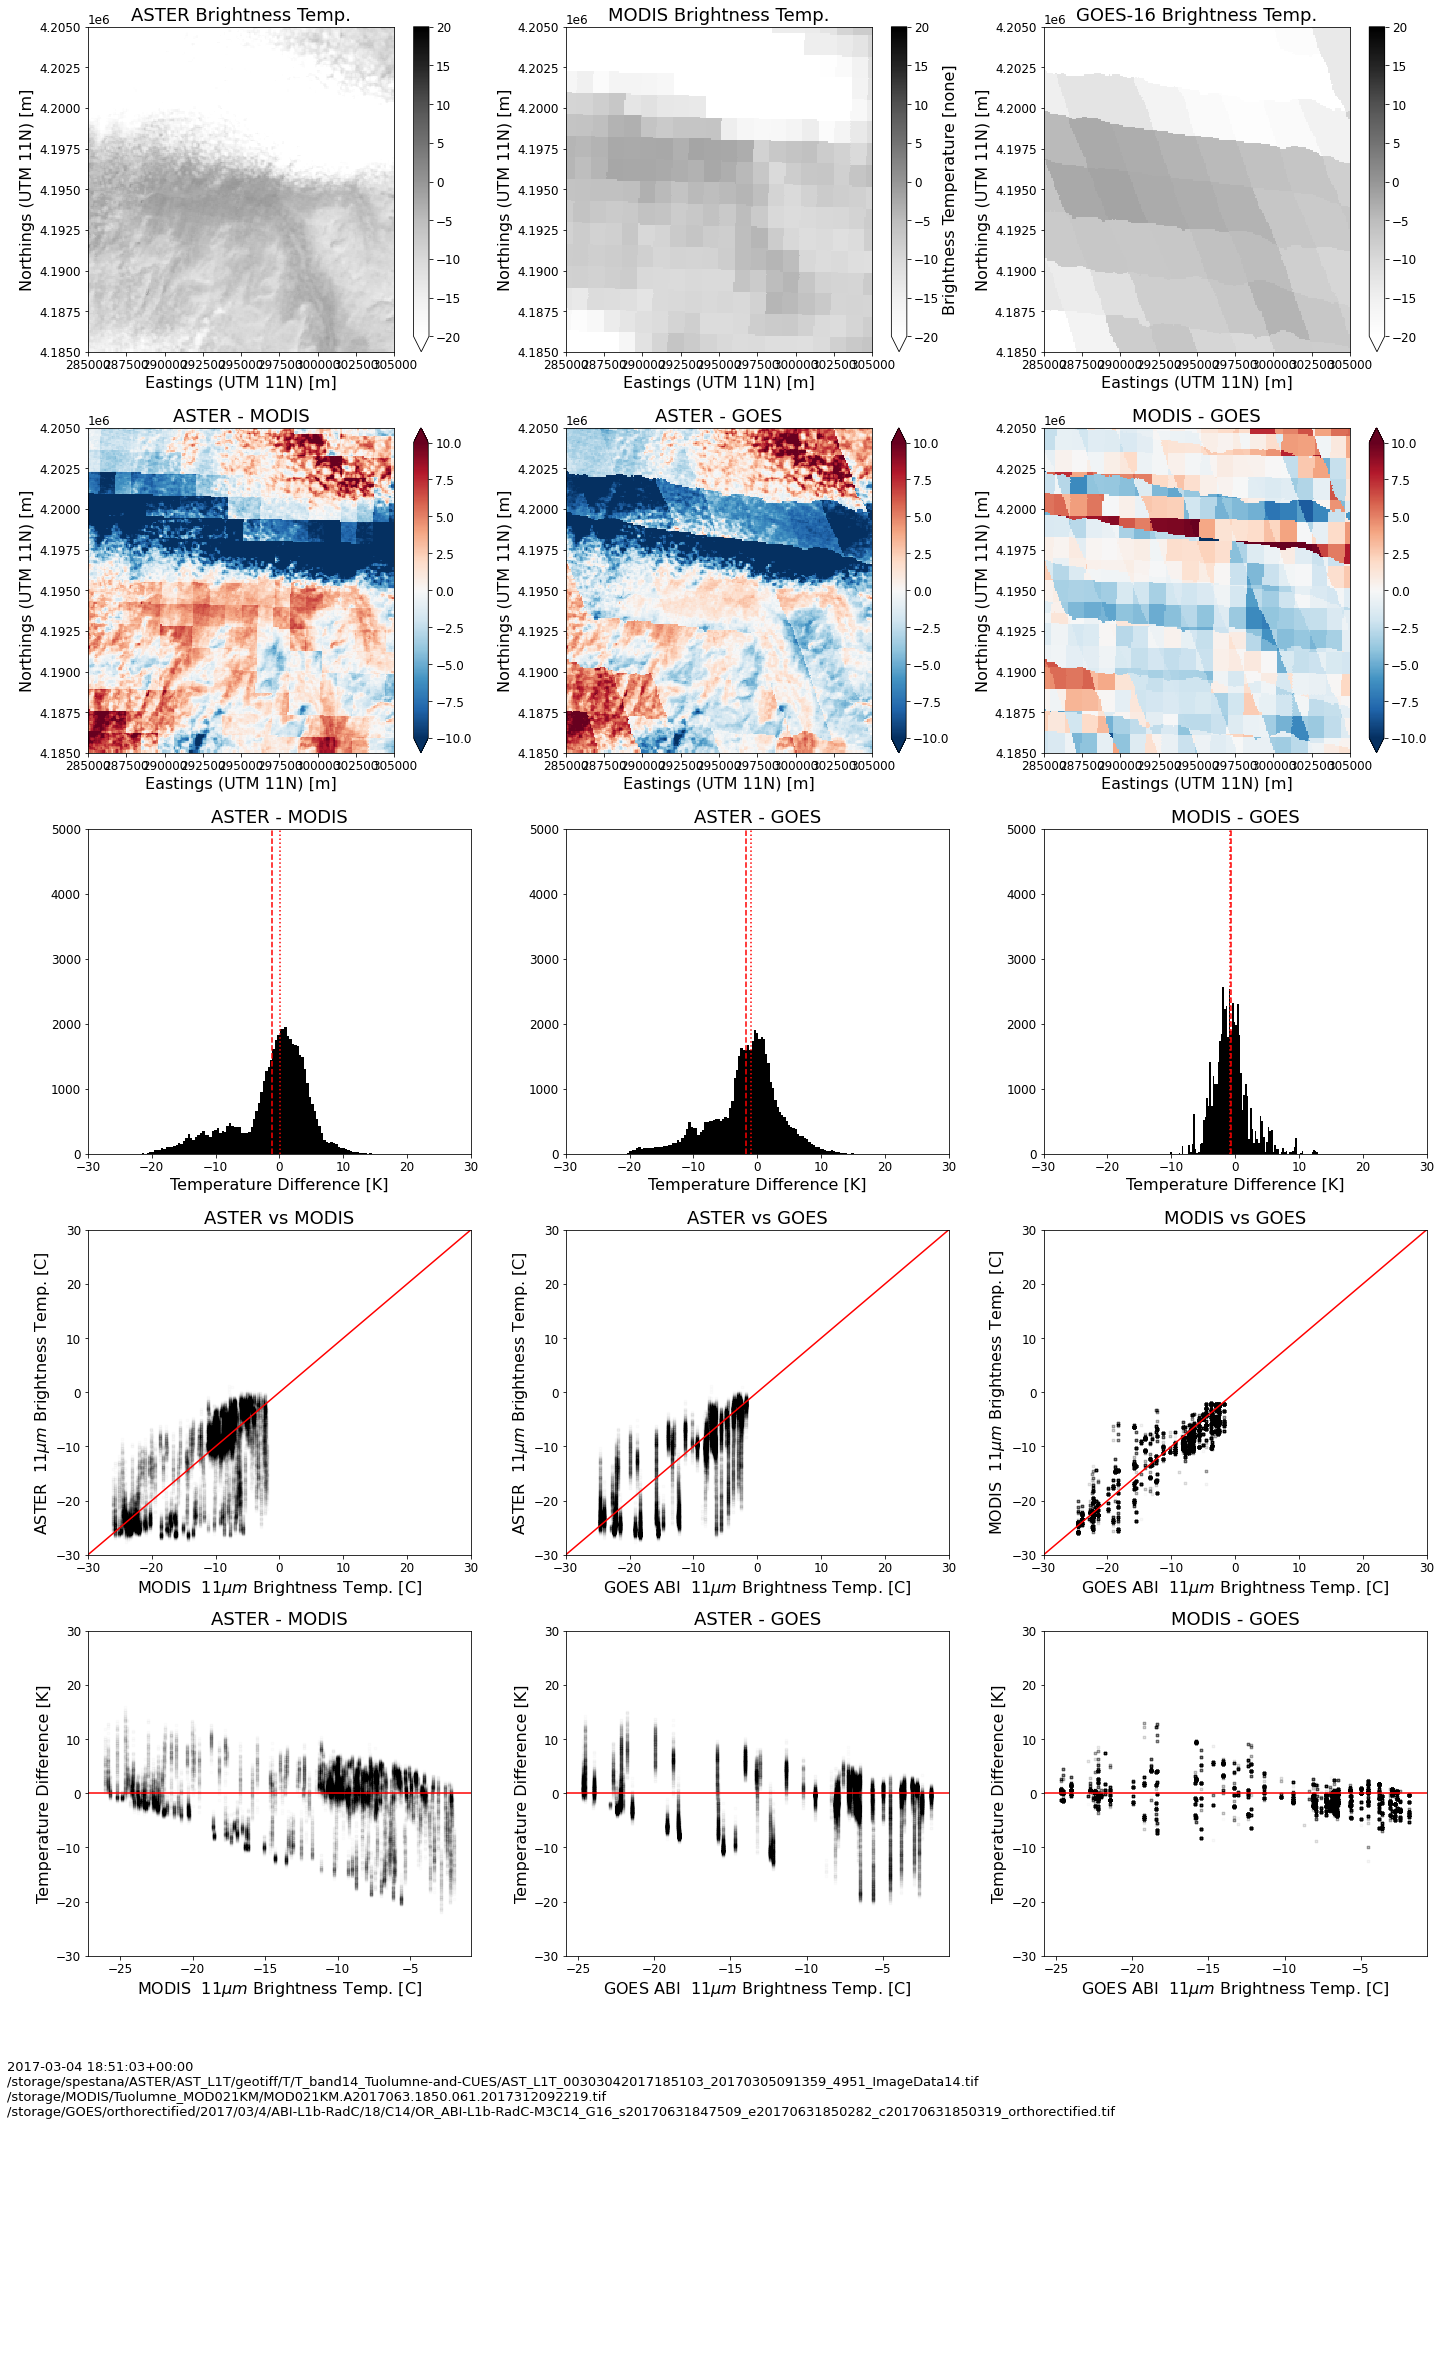

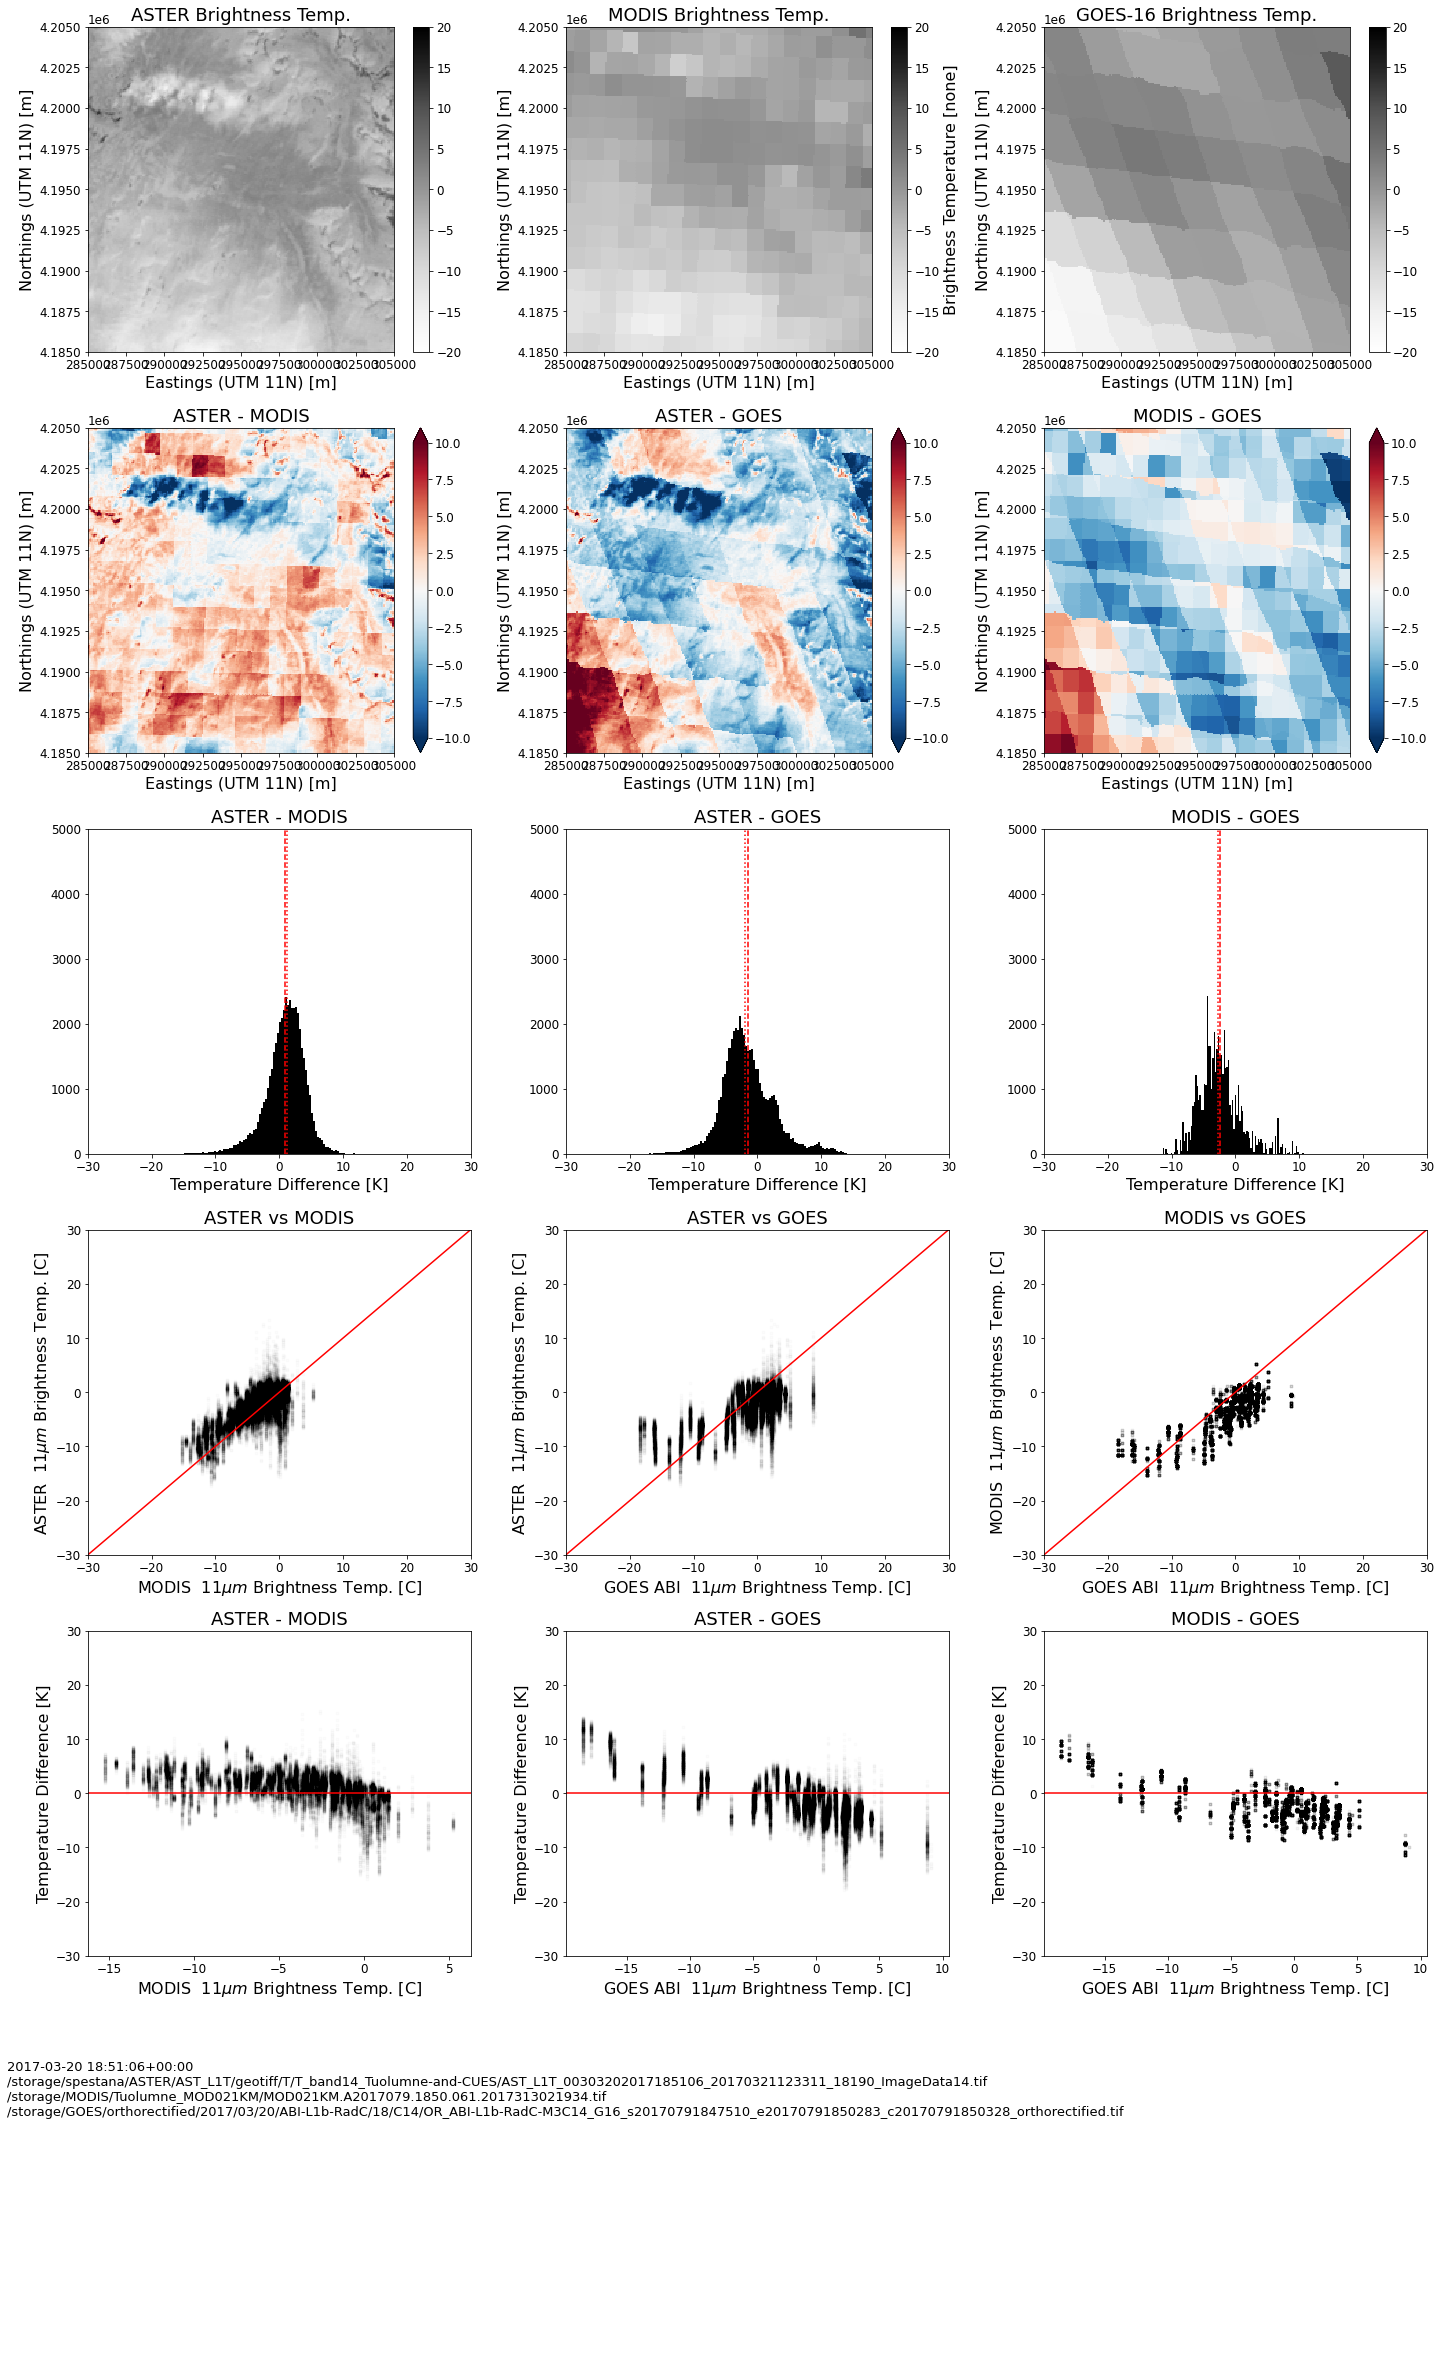

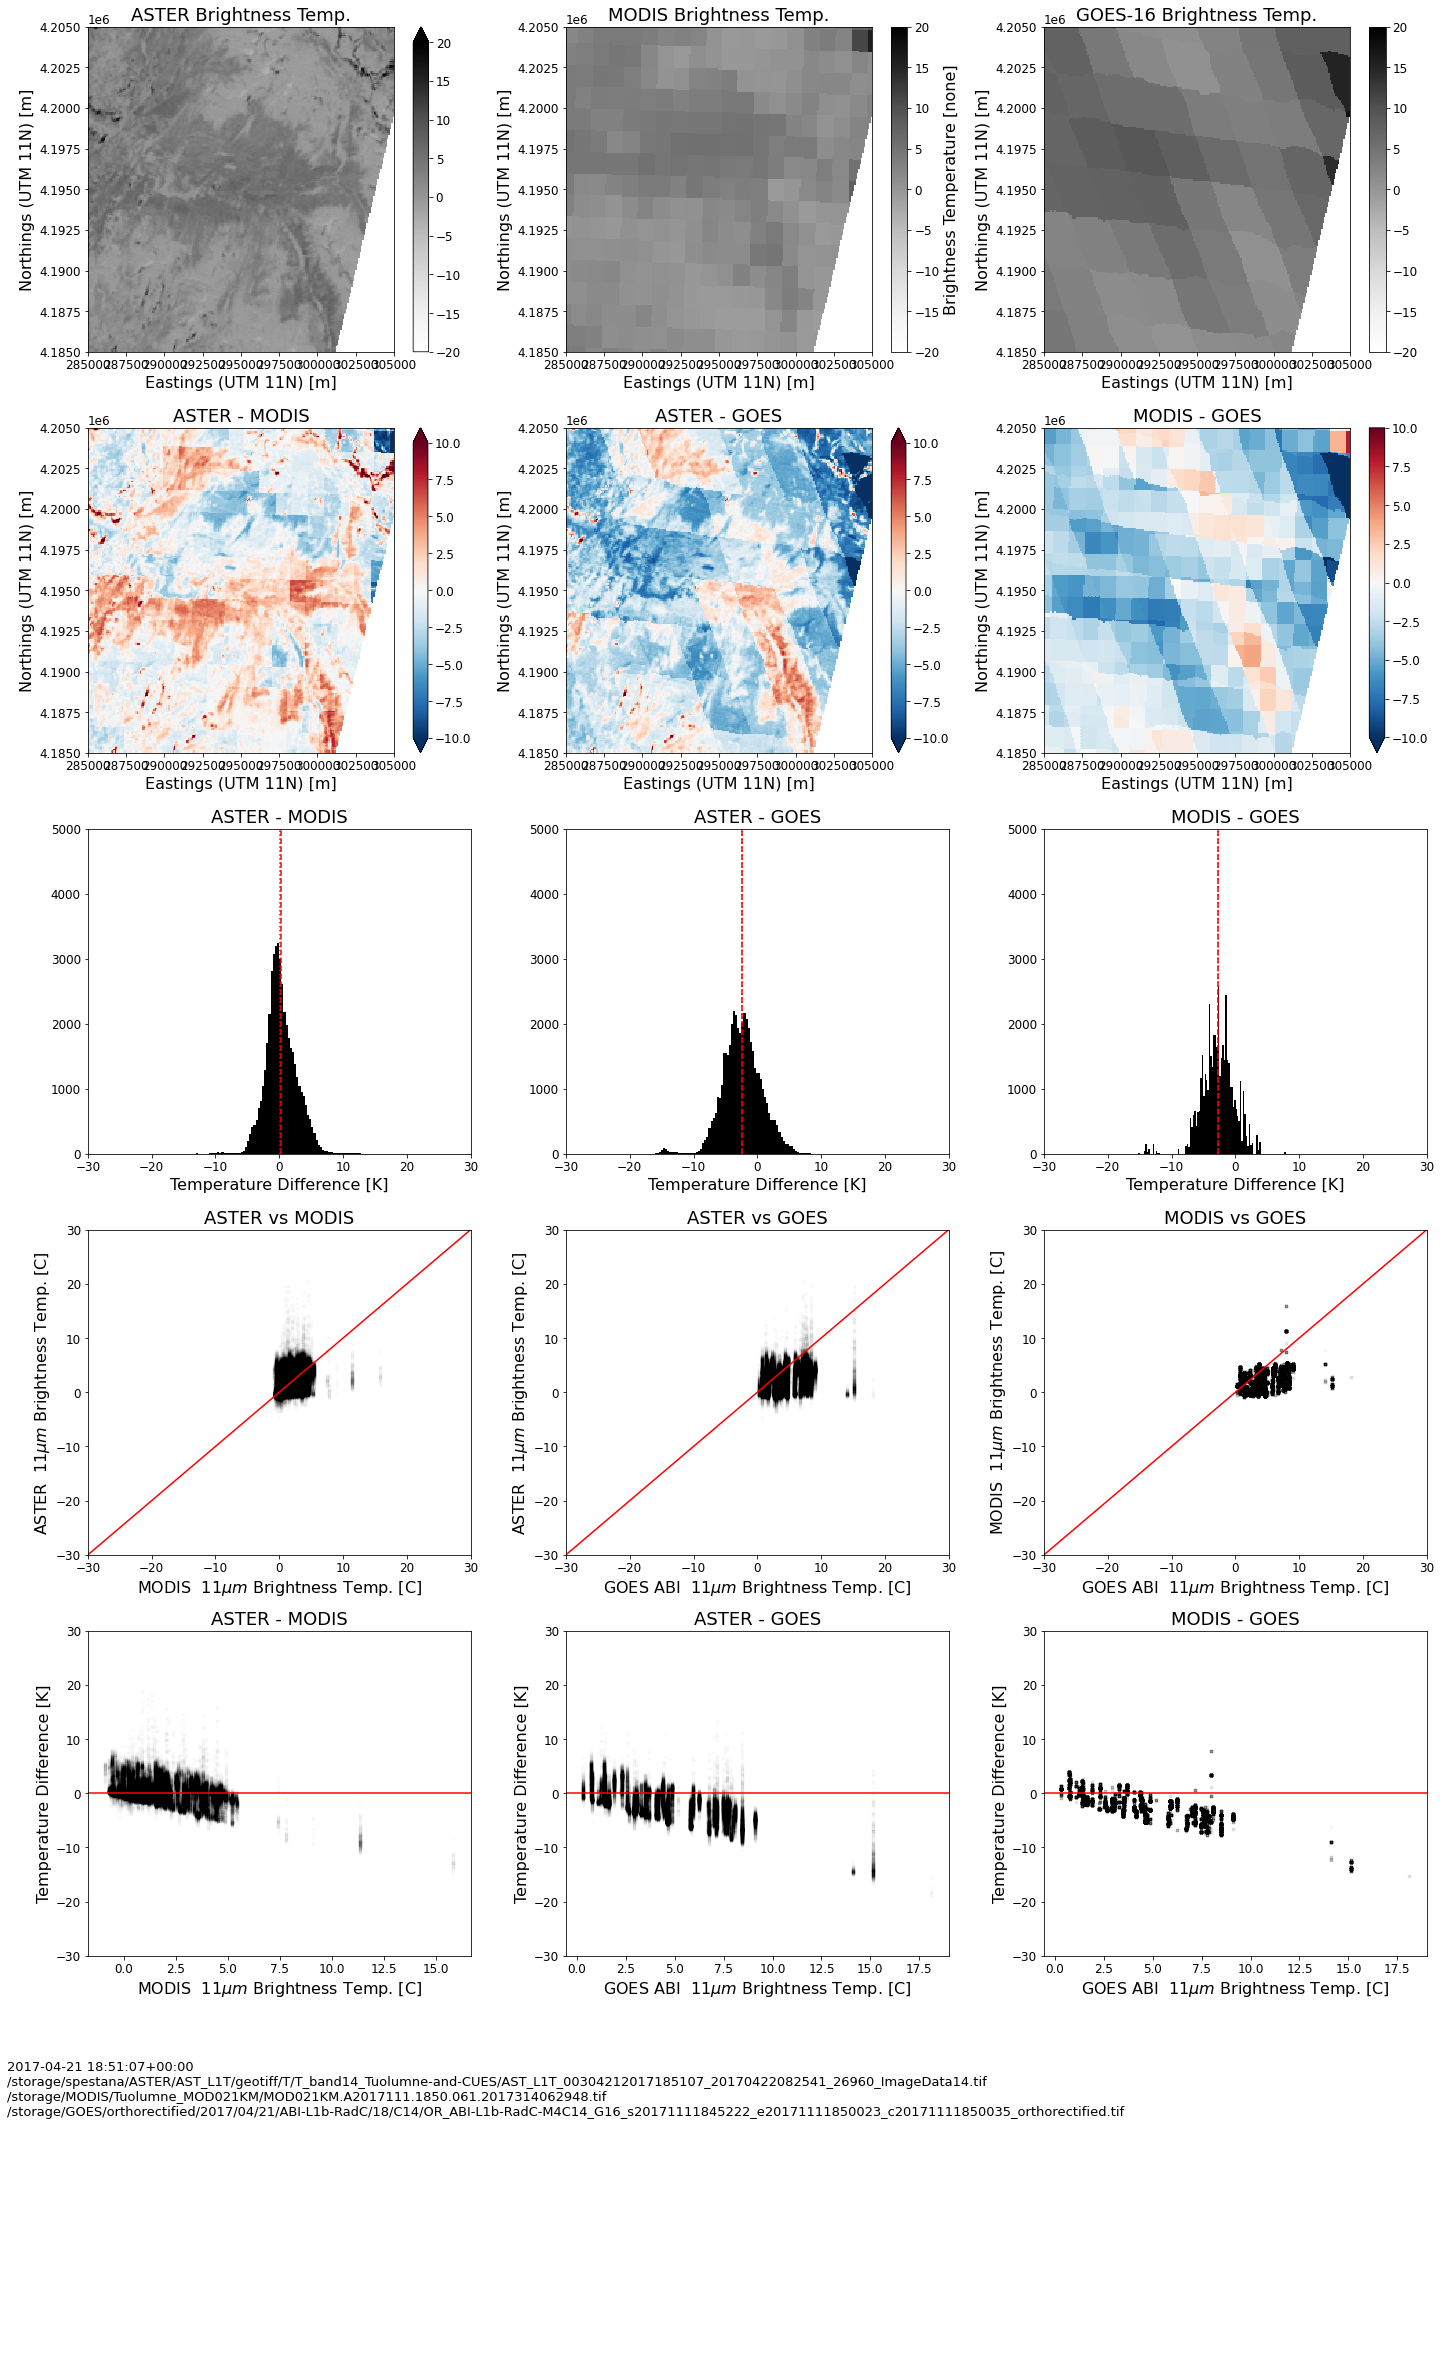

In [14]:
####### Clip all three rasters to the same common area:

# Define a working area here in local UTM coordinates
utm_northings_max = 4205000
utm_northings_min = 4185000
utm_eastings_max = 305000
utm_eastings_min = 285000

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_eastings_min, utm_northings_max],
            [utm_eastings_max, utm_northings_max],
            [utm_eastings_max, utm_northings_min],
            [utm_eastings_min, utm_northings_min]
        ]]
    }
]



#############################################################################

# pick one set of images from our list
for n in range(len(aster[:3])):
    ### Open the ASTER image
    aster_src = xr.open_rasterio(aster.filepath[n])
    # Replace the nodatavals with NaN, squeeze out the band dim we don't need
    aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan).squeeze()
    # Convert ASTER DN to Radiance, and then Brightness Temperature
    aster_band = 14
    aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
    aster_tb =  aster_utils.tir_rad2tb(aster_rad, aster_band)
    # set crs back
    aster_tb.rio.set_crs(aster_src.crs, inplace=True)
    # clip to geometry
    aster_tb = aster_tb.rio.clip(geometries)
    # convert K to C
    aster_tb_degC = aster_tb-273.15
    ######
       
        
    ### Get MODIS image
    # Open the MODIS file
    modis_src = xr.open_rasterio(aster.modis_filepath[n])#aster.modis_filepath[n])
    # convert from DN to Radiance and Brightness Temperature
    modis_ds = modis_utils.emissive_convert_dn(modis_src)
    # use Reproject_Match to reproject the GOES geotiff into the same CRS as the ASTER geotiff
    modis_ds_repr_match = modis_ds.rio.reproject_match(aster_src)
    # clip out anything that is nan in the ASTER image
    modis_ds_repr_match = modis_ds_repr_match.where(np.isnan(aster_src.values) == False)
    # set crs
    #modis_ds_repr_match.rio.set_crs(aster_src.crs, inplace=True)
    # clip to geometry
    modis_ds_repr_match = modis_ds_repr_match.rio.clip(geometries)
    # remove nodata value
    modis_ds_repr_match = modis_ds_repr_match.where(modis_ds_repr_match.tb_c != 65535)
    ######    
        
        
    ### Get GOES image
    # Find the GOES image closest to our ASTER observation
    nearest_goes_datetime_UTC = nearest(list(goes_dict.keys()), aster.timestampUTC[n])
    #print('\t{} -- {}'.format(aster_datetime_UTC, nearest_goes_datetime_UTC))
    nearest_goes_filepath = goes_dict[nearest_goes_datetime_UTC]['filepath']
    # Open the GOES file
    goes_src = xr.open_rasterio(nearest_goes_filepath)
    # use Reproject_Match to reproject the GOES geotiff into the same CRS as the ASTER geotiff
    goes_src_repr_match = goes_src.rio.reproject_match(aster_src)
    # clip out anything that is nan in the ASTER image
    goes_src_repr_match = goes_src_repr_match.where(np.isnan(aster_src.values) == False)
    # clip to geometry
    goes_src_repr_match = goes_src_repr_match.rio.clip(geometries)
    # convert to degrees C, squeeze out extra dim
    goes_img_degC = goes_src_repr_match.squeeze()-273.15
    ######
    
    
    #############################################################################
        

    
    ####### Compute summary stats
    # make sure to use MODIS band 31 (here index 10, it is around 11 microns)
    # See a list of band numbers with: modis_ds_repr_match.band_names.split(',')
    modis_band_index = 10
    
    # ASTER - MODIS
    summary_stats_ast_mod = summary_stats(aster_tb.values.ravel(),  modis_ds_repr_match.tb.isel(band=modis_band_index).values.ravel())
    
    # ASTER - GOES
    summary_stats_ast_goes = summary_stats(aster_tb.values.ravel(),  goes_src_repr_match.values.ravel())
    
    # MODIS - GOES
    summary_stats_mod_goes = summary_stats(modis_ds_repr_match.tb.isel(band=modis_band_index).values.ravel(),  goes_src_repr_match.values.ravel())
    
    # compile summary stats into a pandas dataframe
    #summary_stats_data = {'col1': [1, 2], 'col2': [3, 4]}
    
    #############################################################################


    
    # plotting function
    make_summary_plots( aster_tb_degC, modis_ds_repr_match, goes_img_degC, \
                        summary_stats_ast_mod, summary_stats_ast_goes, summary_stats_mod_goes, \
                        show_figure=True, save_figure=False
                      )